In [1]:
%matplotlib inline
import rasterio as rio
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import os
from scipy.optimize import curve_fit

In [2]:
g17_b02 = xr.open_dataset('/home/jovyan/goes17/2018/12/12/ABI-L1b-RadC/18/C02/OR_ABI-L1b-RadC-M3C02_G17_s20183461827189_e20183461829502_c20183461829528.nc')

In [3]:
def ABIangle2LatLon(x, y, H, req, rpol, lon_0):
    '''Find the latitude and longitude (degrees) of point P given x and y, ABI elevation and scanning angle (radians)'''
    
    # intermediate calculations
    a = np.sin(x)**2 + ( np.cos(x)**2 * ( np.cos(y)**2 + ( req**2 / rpol**2 ) * np.sin(y)**2 ) )
    b = -2 * H * np.cos(x) * np.cos(y)
    c = H**2 - req**2

    rs = ( -b - np.sqrt( b**2 - 4*a*c ) ) / ( 2 * a ) # distance from satellite point (S) to P
    
    Sx = rs * np.cos(x) * np.cos(y)
    Sy = -rs * np.sin(x)
    Sz = rs * np.cos(x) * np.sin(y)
    
    # calculate lat and lon
    lat = np.arctan( ( req**2 / rpol**2 ) * ( Sz / np.sqrt( ( H - Sx )**2 + Sy**2 ) ) )
    lat = np.degrees(lat) #*
    lon = lon_0 - np.degrees( np.arctan( Sy / ( H - Sx )) )
    
    return (lat,lon)



In [14]:
# make a 2d array of both x and y in radians
x, y = np.meshgrid(g17_b02.x.values, g17_b02.y.values)

# Values needed for geometry calculations
req = g17_b02.goes_imager_projection.semi_major_axis # semi major axis
rpol = g17_b02.goes_imager_projection.semi_minor_axis
H = g17_b02.goes_imager_projection.perspective_point_height + g17_b02.goes_imager_projection.semi_major_axis
lon_0 = g17_b02.goes_imager_projection.longitude_of_projection_origin

# Get lat and lon values
lat, lon = ABIangle2LatLon(x,y,H,req,rpol,lon_0)


In [15]:
# Normalize latitude to [-1,1]:
LAT_OFF = lat.min()
LAT_SCALE = lat.max()-lat.min()
lat_norm = 2 * ((lat - LAT_OFF) / LAT_SCALE) - 1

# Normalize longitude to [-1,1]:
LON_OFF = lon.min()
LON_SCALE = lon.max() - lon.min()
lon_norm = 2 * ((lon - LON_OFF) / LON_SCALE) - 1

# Normalize row (y) to [-1,1]:
Y_OFF = y.min()
Y_SCALE = y.max() - y.min()
y_norm = 2 * ((y - Y_OFF) / Y_SCALE) - 1

# Normalize column (x) to [-1,1]:
X_OFF = x.min()
X_SCALE = x.max() - x.min()
x_norm = 2 * ((x - X_OFF) / X_SCALE) - 1

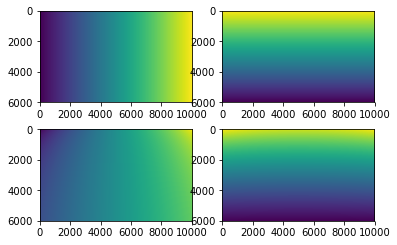

In [22]:
# Visualize the arrays of x, y (scan angle radians), and longitude, latitude (degrees)
fig, ax = plt.subplots(2,2)
ax[0,0].imshow(x_norm)
ax[0,1].imshow(y_norm)
ax[1,0].imshow(lon_norm)
ax[1,1].imshow(lat_norm)

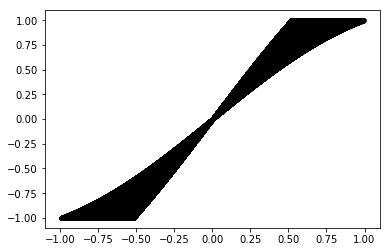

In [11]:
# Visualize longitude (degrees) vs x (scan angle radians)
plt.plot(lon_norm,x_norm,'.k',alpha=0.01);

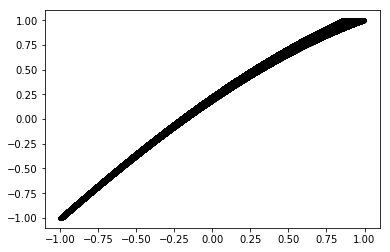

In [12]:
# Visualize latitude (degrees) vs y (scan angle radians)
plt.plot(lat_norm,y_norm,'.k',alpha=0.01);

In [29]:
# Fit RPCs to these two surfaces:

#do 2 fittings for x and y seperately (here l and s)
#function accepts 2 tuples as input first contains x,y,z and 2nd contains 40 coefficients
#using scipy curve fitting wont require to initialise the tuples

# https://stackoverflow.com/questions/19165259/python-numpy-scipy-curve-fitting
    

In [16]:
def map2rpc(in_xyz,
            a0,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,a15,a16,a17,a18,a19,
            b0,b1,b2,b3,b4,b5,b6,b7,b8,b9,b10,b11,b12,b13,b14,b15,b16,b17,b18,b19):
    
    (x, y, z) = in_xyz
    
    num_l = a0 + a1*x + a2*y + a3*z + a4*x*y + a5*x*z + a6*y*z + a7*x**2 + a8*y**2 + a9*z**2 + a10*x*y*z + a11*x**3 + a12*x*y**2 + \
    a13**x*z**2 + a14*y*x**2 + a15*y**3 + a16*y*z**2 + a17*x**2*z + a18*y**2*z + a19*z**3
    
    den_l = b0 + b1*x + b2*y + b3*z + b4*x*y + b5*x*z + b6*y*z + b7*x**2 + b8*y**2 + b9*z**2 + b10*x*y*z + b11*x**3 + b12*x*y**2 + \
    b13**x*z**2 + b14*y*x**2 + b15*y**3 + b16*y*z**2 + b17*x**2*z + b18*y**2*z + b19*z**3
    
    return num_l/den_l

In [94]:
def fn(x, a, b, c, d):
    return a*x**2 +b*x**3 + c*x + d

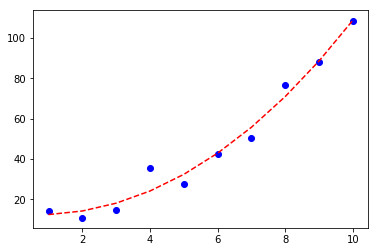

In [96]:
x = np.linspace(1,10,10)
y = np.zeros_like(x)
c=0
for i in x:
    y[c] = i**2 + np.random.rand()*20
    c+=1

plt.plot(x,y,'ob')

fit = curve_fit(fn, x, y)
a,b,c,d = fit[0]
y2 = a*x**2 +b*x**3 + c*x + d
plt.plot(x,y2,'--r')

In [17]:
# set elevations to 0, on the surface of the ellipsoid
z = np.zeros_like(lat_norm)

In [18]:
a = curve_fit(map2rpc, [np.ma.compressed(lon_norm[0:50]), np.ma.compressed(lat_norm[0:50]), np.ma.compressed(z[0:50])], np.ma.compressed(x_norm[0:50]))

/srv/conda/lib/python3.6/site-packages/scipy/optimize/minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [ ]:
b = curve_fit(map2rpc, [lon_norm, lat_norm ,z], y_norm)

In [19]:
a

(array([-7.11331512e-01, -1.60400670e-01,  1.26378970e+00,  1.00000000e+00,
         8.30835548e+01,  1.00000000e+00,  1.00000000e+00, -4.94607655e-01,
         3.45715543e-02,  1.00000000e+00,  1.00000000e+00, -7.93338048e+00,
        -1.75607170e-02,  1.00000000e+00,  1.77285426e-01, -6.31601027e-01,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         3.10700597e+01,  7.23363015e-03, -6.66733283e-02,  1.00000000e+00,
        -1.58465072e-01,  1.00000000e+00,  1.00000000e+00,  2.63433910e+00,
         3.00085691e-02,  1.00000000e+00,  1.00000000e+00,  2.02710322e-04,
        -2.10309299e-01,  1.00000000e+00,  1.31899299e-02,  4.13134434e+01,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00]),
 array([[inf, inf, inf, ..., inf, inf, inf],
        [inf, inf, inf, ..., inf, inf, inf],
        [inf, inf, inf, ..., inf, inf, inf],
        ...,
        [inf, inf, inf, ..., inf, inf, inf],
        [inf, inf, inf, ..., inf, inf, inf],
